# 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)
- https://wikidocs.net/44249

In [2]:
!pip install konlpy > /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

### 1.1 데이터 로드하기

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f0a5001ef10>)

In [5]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [7]:
# 1이 긍정, 0이 부정
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


### 1.2 데이터 정제하기

- train 데이터

In [9]:
# 중복 데이터 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [10]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


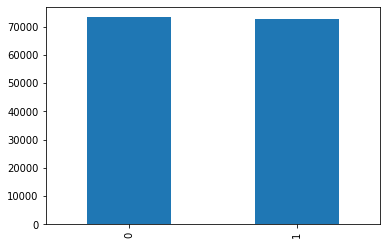

In [12]:
# 0과 1의 편향 확인 => 편향되지 않음
train_data['label'].value_counts().plot(kind = 'bar')

In [13]:
print(train_data.isnull().values.any())

True


In [14]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [15]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data))

146182


- test 데이터

In [18]:
# 테스트 데이터에 대해서도 동일하게 전처리하기
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [20]:
test_data['document'].nunique()

49157

In [21]:
test_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

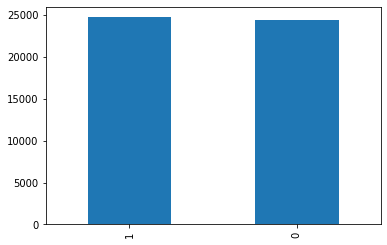

In [26]:
# 0과 1의 편향 확인 => 편향되지 않음
test_data['label'].value_counts().plot(kind = 'bar')

In [25]:
print(test_data.isnull().values.any()) # null값이 있는지 확인

True


In [28]:
print(test_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [29]:
test_data.loc[test_data.document.isnull()] # null값인 데이터 확인

,id,document,label
5746,402110,NaN,1


In [31]:
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [32]:
print(len(test_data))

49157


- 데이터 정제

In [33]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [34]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['document'].replace('', np.nan, inplace=True)
print(test_data.isnull().sum())

id            0
document    789
label         0
dtype: int64
id            0
document    305
label         0
dtype: int64


In [35]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

test_data = test_data.dropna(how = 'any')
print(len(test_data))

145393
48852


- 작업량을 줄이기: 결과물이 좋지 않음.

In [36]:
train_data = train_data[:1000]
test_data = test_data[:1000]

### 1.3 토큰화

In [37]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [38]:
okt = Okt() # 형태소 분석기

# train 데이터
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 1000/1000 [00:12<00:00, 78.93it/s]


In [39]:
print(X_train[:3]) # 상위 3개의 샘플만 결과 확인

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [40]:
# 테스트 데이터
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 1000/1000 [00:03<00:00, 254.52it/s]


### 1.4 정수 인코딩

In [41]:
# 훈련 데이터에 대해서 단어 집합을 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [42]:
# 각 단어에 부여된 고유한 정수 확인
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '있다': 5, '이다': 6, '좋다': 7, '다': 8, '진짜': 9, '적': 10, '정말': 11, '너무': 12, '아니다': 13, '재밌다': 14, '만': 15, '되다': 16, '같다': 17, '연기': 18, '인': 19, '나오다': 20, '로': 21, '최고': 22, '안': 23, '점': 24, '에서': 25, '사람': 26, '내': 27, '않다': 28, '보고': 29, '그': 30, '만들다': 31, '것': 32, '왜': 33, '못': 34, '하고': 35, '나': 36, '감동': 37, '말': 38, '재미': 39, '아깝다': 40, '고': 41, '재미없다': 42, '싶다': 43, 'ㅋㅋ': 44, '재미있다': 45, '생각': 46, '내용': 47, '배우': 48, '더': 49, '아': 50, '그냥': 51, '드라마': 52, '중': 53, '시간': 54, '평점': 55, '때': 56, '스토리': 57, '들다': 58, '감독': 59, '알다': 60, '쓰레기': 61, '하나': 62, '게': 63, '그렇다': 64, '작품': 65, '볼': 66, 'ㅠㅠ': 67, '자다': 68, '완전': 69, '요': 70, '모르다': 71, '또': 72, '주인공': 73, '개': 74, '기': 75, '지루하다': 76, '정도': 77, '주다': 78, '느낌': 79, '거': 80, '년': 81, '네': 82, '듯': 83, '오다': 84, 'ㅋㅋㅋ': 85, '돈': 86, '가다': 87, '지': 88, '수': 89, '다시': 90, '일': 91, '뭐': 92, '먹다': 93, '이건': 94, 'ㅡㅡ': 95, '이렇다': 96, '라': 97, '냐': 98, '마지막': 99, '안되다': 100, '난': 101, '인생': 102, '사

In [43]:
# 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3285
등장 빈도가 2번 이하인 희귀 단어의 수: 2489
단어 집합에서 희귀 단어의 비율: 75.76864535768645
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 26.91852526172053


In [44]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 797


In [45]:
# 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [46]:
# X_train에 대해서 상위 3개의 샘플만 출력
print(X_train[:3])

[[50, 356, 9, 170], [220, 29, 570, 1, 107, 571, 18, 572, 28], [436, 2, 287, 8]]


In [47]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 1.5 빈 샘플 제거

In [50]:
# 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미
# 빈 샘플들을 제거
# 길이가 0인 샘플들의 인덱스
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [51]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

984
984


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 1.6 패딩

리뷰의 최대 길이 : 38
리뷰의 평균 길이 : 8.158536585365853


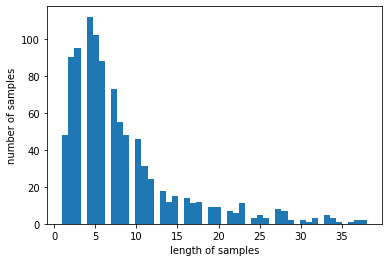

In [52]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [53]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [57]:
max_len = 25
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 95.9349593495935


In [58]:
# 모든 샘플의 길이를 25로 맞춤
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [59]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
embedding_dim = 100  # 임베딩 벡터의 차원
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units)) # 리뷰 분류를 위해서 LSTM 사용
model.add(Dense(1, activation='sigmoid'))

In [61]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [62]:
# 에포크는 총 15번을 수행
# 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
13/13 [==============================] - 5s 137ms/step - loss: 0.6885 - acc: 0.5794 - val_loss: 0.6894 - val_acc: 0.5076

Epoch 00001: val_acc improved from -inf to 0.50761, saving model to best_model.h5
Epoch 2/15
13/13 [==============================] - 1s 67ms/step - loss: 0.6356 - acc: 0.7471 - val_loss: 0.6267 - val_acc: 0.6650

Epoch 00002: val_acc improved from 0.50761 to 0.66497, saving model to best_model.h5
Epoch 3/15
13/13 [==============================] - 1s 66ms/step - loss: 0.4983 - acc: 0.8196 - val_loss: 0.6092 - val_acc: 0.6802

Epoch 00003: val_acc improved from 0.66497 to 0.68020, saving model to best_model.h5
Epoch 4/15
13/13 [==============================] - 1s 67ms/step - loss: 0.4264 - acc: 0.8399 - val_loss: 0.6201 - val_acc: 0.6802

Epoch 00004: val_acc did not improve from 0.68020
Epoch 5/15
13/13 [==============================] - 1s 66ms/step - loss: 0.3410 - acc: 0.8679 - val_loss: 0.7643 - val_acc: 0.6701

Epoch 00005: val_acc did not improve 

In [63]:
# 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5'를 로드

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

32/32 [==============================] - 1s 11ms/step - loss: 0.5970 - acc: 0.6840

 테스트 정확도: 0.6840


## 3. 리뷰 예측해보기

In [64]:
#  model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 함
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [65]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

65.44% 확률로 긍정 리뷰입니다.



In [70]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

68.70% 확률로 긍정 리뷰입니다.



In [67]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

52.19% 확률로 부정 리뷰입니다.



In [68]:
sentiment_predict('감독 뭐하는 놈이냐?')

66.01% 확률로 부정 리뷰입니다.



In [69]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

60.28% 확률로 긍정 리뷰입니다.

